# Support Vector Machines in OpenCV

Aim: build an Optical Character Recognition (OCR) classifier to recognize handwritten digits.

The training data is sourced from a large image containing 5000 20x20 grayscale samples with a black background:

![](images/digits.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

image = cv2.imread('images/digits.png', 0)

## Split Input Image into Datasets

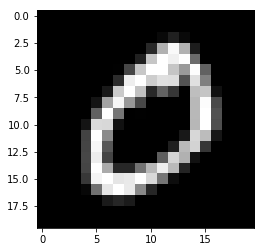

In [2]:
# 100 examples of each 20x20 image
cells = [np.hsplit(row, 100) for row in np.vsplit(image, 50)]
# show first example of 0 digit
plt.imshow(cells[0][0], cmap='gray')

In [3]:
train_cells = [i[:50] for i in cells]
test_cells = [i[50:] for i in cells]

## Deskew Images
Many digits are written at an angle (skewed), aligning them prior to training produces more consistent results.

![](images/deskew.png)

The skew of grayscale images can be measure using the ratio of the two central image moments.

An affine transformation can then be calculated to deskew the image

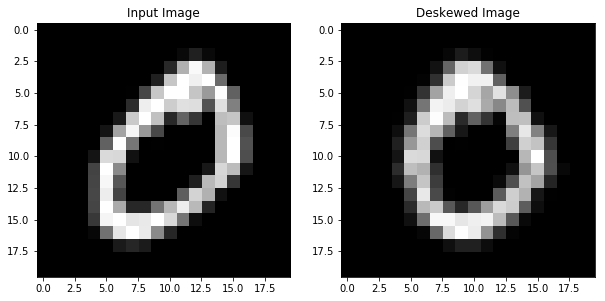

In [18]:
image_size = 20

def deskew_image(image, skew_threshold=1e-2):
    m = cv2.moments(image)
    if abs(m['mu02']) < skew_threshold:
        return image.copy()
    # skew based on central momemts
    skew = m['mu11']/m['mu02']
    # affine transform to correct skewness. 
    M = np.float32([[1, skew, -0.5*image_size*skew], [0, 1, 0]])
    # apply affine transform
    image = cv2.warpAffine(image, M, (image_size, image_size), flags=cv2.WARP_INVERSE_MAP| cv2.INTER_LINEAR)
    return image

deskewed = [list(map(deskew_image, row)) for row in train_cells]

# plot first cell as example
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,10))
ax1.set_title('Input Image')
ax1.imshow(train_cells[0][0], cmap='gray')
ax2.set_title('Deskewed Image')
ax2.imshow(deskewed[0][0], cmap='gray')

## Compute Feature Vectors using Histogram of Oriented Gradients

In [43]:
def block_array(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))
n_bins = 16 
n_blocks = 4 # must be power of 2 to split image evenly

def hog(img):
    #set_trace()
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    mag, ang = cv2.cartToPolar(gx, gy)
    # quantizing binvalues in (0...n_bins)
    bins = np.int32(n_bins*ang/(2*np.pi))    
    
    # Divide to n_blocks sub-squares
    block_size = int(img.shape[0]/(n_blocks/2))
    bin_cells = block_array(bins, block_size, block_size)
    mag_cells = block_array(mag, block_size, block_size)
    # calculate histogram weighted by direction
    hists = [np.bincount(b.ravel(), m.ravel(), n_bins) for b, m in zip(bin_cells, mag_cells)]
    # hist is a n_bins*n_blocks bit vector
    hist = np.hstack(hists)
    return hist

hog_features = [list(map(hog, row)) for row in deskewed]

## Build Labels
Input image contains 500 samples each of the digits 0-10. The training data contains **half** these samples. The training data order is the same as the original image, so labels need to be 250 each of the digits 0-10 in order:
* i.e. indexes 0->249 = 0.0, 250->499 = 1.0 etc

OpenCv SVM requires labels in a 2D array, so labels array should have shape `(2500, 1)`

In [37]:
label_values = np.int32(np.repeat(np.arange(10), 250))
# add extra axis to make 2D array
labels = label_values[:, np.newaxis]

## Train SVM

In [38]:
# svm takes np array of float32 as input
train_data = np.float32(hog_features).reshape(-1, 64)
# Initialize the SVM
svm = cv2.ml.SVM_create()
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setType(cv2.ml.SVM_C_SVC)
svm.setC(2.67)
svm.setGamma(5.383)

svm.train(train_data,cv2.ml.ROW_SAMPLE, labels)
svm.save('data/svm_digits_data.dat')

## Test SVM

In [40]:
deskewed = [list(map(deskew_image, row)) for row in test_cells]
hog_features = [list(map(hog, row)) for row in deskewed]
test_data = np.float32(hog_features).reshape(-1,n_bins*4)
result = svm.predict(test_data)[1]

In [42]:
mask = result==labels
correct = np.count_nonzero(mask)
print(correct*100.0/result.size)

93.8
